In [15]:
import torch
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt
import pandas as pd

class ErasplitGBDT(BaseEstimator, RegressorMixin):
    def __init__(self, num_bins=10, max_depth=3, learning_rate=0.1, n_estimators=100):
        self.num_bins = num_bins
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.forest = None
        self.bin_edges = None
        self.base_prediction = None
        self.unique_eras = None
        self.device = "cuda"
        self.root_gradient_histogram = None
        self.root_hessian_histogram = None
        self.gradients = None
        self.root_node_indices = None
        self.bin_indices = None
        self.Y_gpu = None
        self.num_features = None
        self.num_samples = None
        self.feature_offset = None
        
    def fit(self, X, y, era_id):
        self.bin_indices, era_indices, self.bin_edges, self.unique_eras, self.Y_gpu = self.preprocess_gpu_data(X, y, era_id)

        self.gradients = torch.zeros_like(self.Y_gpu)
        self.root_node_indices = torch.arange(self.num_samples, device=self.device)

        self.base_prediction = self.Y_gpu.mean().item()
        self.gradients += self.base_prediction  # initialize with mean

        self.feature_offset = self.num_samples * torch.arange(self.num_features, device=self.device)

        self.forest = self.grow_forest()

        return self

    def predict(self, X):
        X_tensor = torch.from_numpy(X).float().to(self.device)
        preds = self.predict_forest_batch( X_tensor )
        return preds.cpu().numpy()

    def compute_quantile_bins(self, X, num_bins):
        quantiles = torch.linspace(0, 1, num_bins + 1)[1:-1]  # Exclude 0% and 100%
        bin_edges = torch.quantile(X, quantiles, dim=0)  # shape: [B-1, F]
        return bin_edges.T  # shape: [F, B-1]
    
    def preprocess_gpu_data(self, X_np, Y_np, era_id_np):
        self.num_samples, self.num_features = X_np.shape
    
        X = torch.from_numpy(X_np).type(torch.float32)
        Y_gpu = torch.from_numpy(Y_np).type(torch.float32).to(self.device)
        era_id_gpu = torch.from_numpy(era_id_np).type(torch.int32).to(self.device)
    
        bin_edges = self.compute_quantile_bins(X, self.num_bins).type(torch.float32).contiguous()
    
        bin_indices = torch.empty((self.num_samples * self.num_features,), dtype=torch.int32)
        for f in range(self.num_features):
            bin_indices[f*self.num_samples:(f+1)*self.num_samples] = (f*self.num_bins) + torch.bucketize(X[:, f], bin_edges[f], right=False)
        bin_indices = bin_indices.to(self.device).contiguous()
        bin_edges = bin_edges.to(self.device)
    
        unique_eras, era_indices = torch.unique(era_id_gpu, return_inverse=True)
    
        return bin_indices, era_indices, bin_edges, unique_eras, Y_gpu
        
    def compute_histograms(self, bin_indices_sub, gradients):
        num_bins_total = self.num_features * self.num_bins
    
        gradient_histogram = torch.zeros(num_bins_total, device=self.device, dtype=torch.float32)
        hessian_histogram = torch.zeros(num_bins_total, device=self.device, dtype=torch.float32)
    
        repeated_gradients = gradients.repeat(self.num_features)
    
        gradient_histogram.index_add_(
            0, bin_indices_sub, repeated_gradients
        )
    
        hessian_histogram.index_add_(
            0, bin_indices_sub, torch.ones_like(repeated_gradients)
        )
    
        return gradient_histogram, hessian_histogram
    
    def find_best_split(self, gradient_histogram, hessian_histogram):
        F = self.num_features
        B = self.num_bins
        eps = 1e-6
    
        G = gradient_histogram.view(F, B)
        H = hessian_histogram.view(F, B)
    
        G_L = torch.cumsum(G[:, :-1], dim=1)
        H_L = torch.cumsum(H[:, :-1], dim=1)
    
        G_total = G[0,:].sum()
        H_total = H[0,:].sum()
    
        G_R = G_total - G_L
        H_R = H_total - H_L
    
        # Compute gain
        gain = (G_L ** 2) / (H_L + eps) + (G_R ** 2) / (H_R + eps)
    
        # Mask out invalid splits where left or right side is empty or gain is non-positive
        valid_mask = (H_L > 0) & (H_R > 0) & (gain > 0)
    
        if not valid_mask.any():
            return None, None
    
        # Flatten and apply mask
        flat_gain = gain.flatten()
        flat_mask = valid_mask.flatten()
    
        best_idx = torch.argmax(flat_gain * flat_mask)  # gain * 0 = 0 for invalids
        best_feature = best_idx // (B - 1)
        best_bin = best_idx % (B - 1)
    
        return best_feature, best_bin

    def gather_bin_indices(self, node_indices):
        return self.bin_indices[
            node_indices.repeat(self.num_features) +
            self.feature_offset.repeat_interleave(len(node_indices))
        ]
    
    def grow_tree(
        self,
        gradient_histogram,
        hessian_histogram,
        node_indices,  
        depth
    ):

        # print('---')
        # print(gradient_histogram)
        # print(hessian_histogram)
        
        if depth == self.max_depth:
            leaf_value = (self.Y_gpu[node_indices] - self.gradients[node_indices]).mean()
            self.gradients[node_indices] += self.learning_rate * leaf_value  # Boost original predictions
            return {"leaf_value": leaf_value, "samples": node_indices.numel()}
    
        best_feature, best_bin = self.find_best_split(
            gradient_histogram, hessian_histogram
        )

        if best_feature is None:
            leaf_value = (self.Y_gpu[node_indices] - self.gradients[node_indices]).mean()
            self.gradients[node_indices] += self.learning_rate * leaf_value  # Boost original predictions
            return {"leaf_value": leaf_value, "samples": node_indices.numel()}
    
        split_mask = self.bin_indices[(best_feature * self.num_samples) + node_indices] % self.num_bins <= best_bin
        left_indices = node_indices[split_mask]
        right_indices = node_indices[~split_mask]
        left_size, right_size = left_indices.numel(), right_indices.numel()

        # print("left size: ", left_size, "right size: ", right_size)
    
        if left_size == 0 or right_size == 0:
            leaf_value = (self.Y_gpu[node_indices] - self.gradients[node_indices]).mean()
            self.gradients[node_indices] += self.learning_rate * leaf_value  # Boost original predictions
            return {"leaf_value": leaf_value, "samples": node_indices.numel()}

        

        if left_size < right_size:
            gradient_histogram_left, hessian_histogram_left = self.compute_histograms(self.gather_bin_indices(left_indices), self.residual[left_indices])
            gradient_histogram_right = gradient_histogram - gradient_histogram_left
            hessian_histogram_right = hessian_histogram - hessian_histogram_left
        else:
            gradient_histogram_right, hessian_histogram_right = self.compute_histograms(self.gather_bin_indices(right_indices), self.residual[right_indices])
            gradient_histogram_left = gradient_histogram - gradient_histogram_right
            hessian_histogram_left = hessian_histogram - hessian_histogram_right
            
        new_depth = depth + 1
        left_child = self.grow_tree(gradient_histogram_left, hessian_histogram_left, left_indices, new_depth)
        right_child = self.grow_tree(gradient_histogram_right, hessian_histogram_right, right_indices, new_depth)
    
        return {
            "feature": best_feature,
            "bin": best_bin,
            "left": left_child,
            "right": right_child
        }
    
    def grow_forest(self):
        forest = [{}] * self.n_estimators
    
        for i in range(self.n_estimators):
            self.residual = self.Y_gpu - self.gradients
            self.root_gradient_histogram, self.root_hessian_histogram = self.compute_histograms(self.bin_indices, self.residual)

            tree = self.grow_tree(self.root_gradient_histogram, self.root_hessian_histogram,self.root_node_indices, depth=0)
            
            forest[i] = tree
    
        return forest
    
    def predict_from_tree_batch(self, tree, X_batch):
        N = X_batch.shape[0]
        predictions = torch.empty(N, device=X_batch.device)
    
        active_nodes = [tree for _ in range(N)]
        mask = torch.ones(N, dtype=torch.bool, device=X_batch.device)
    
        while mask.any():
            current_nodes = active_nodes
            new_nodes = [None] * N
            for i in torch.where(mask)[0]:
                node = current_nodes[i]
                if "leaf_value" in node:
                    predictions[i] = node["leaf_value"]
                    mask[i] = False
                else:
                    feature = node["feature"]
                    bin_threshold = node["bin"]
                    bin_index = torch.bucketize(X_batch[i, feature], self.bin_edges[feature], right=False)
                    new_nodes[i] = node["left"] if bin_index <= bin_threshold else node["right"]
    
            active_nodes = new_nodes
    
        return predictions
    
    def predict_forest_batch(self, X_batch ):
        N = X_batch.shape[0]
        preds = torch.full((N,), self.base_prediction if self.base_prediction is not None else 0.0, device=X_batch.device, dtype=torch.float32)
    
        for tree in self.forest:
            preds += self.learning_rate * self.predict_from_tree_batch(tree, X_batch)
    
        return preds



In [53]:
'''
Datasets:

1) Test 2D Dataset with visualization
2) Test High Dimensional Data Set
3) Numerai Data

'''


#1


# # Generate a simple 2D dataset
num_samples = 1000  # Keep it small for clarity

# Generate X in a fun spiral-ish pattern plus some noise
r = np.linspace(0.5, 2.5, num_samples)
theta = np.linspace(0, 4 * np.pi, num_samples)
X1 = r * np.cos(theta) + np.random.normal(0, 0.2, num_samples)
X2 = r * np.sin(theta) + np.random.normal(0, 0.2, num_samples)
X_np = np.stack([X1, X2], axis=1)

# Create a more interesting non-linear target
Y_np = (X_np[:, 0]**2 - X_np[:, 1]**2) + 0.5 * X_np[:, 0]
eras = np.zeros(num_samples)


#2

# def generate_spiral_dataset(num_samples=1_000_000, num_features=10, noise_std=0.2, seed=42):
#     np.random.seed(seed)

#     # Spiral base in 2D
#     r = np.linspace(0.5, 2.5, num_samples)
#     theta = np.linspace(0, 4 * np.pi, num_samples)
#     X1 = r * np.cos(theta) + np.random.normal(0, noise_std, num_samples)
#     X2 = r * np.sin(theta) + np.random.normal(0, noise_std, num_samples)
    
#     # Initial 2D spiral features
#     X = [X1, X2]
    
#     # Create additional synthetic features (some linear, some non-linear)
#     for i in range(2, num_features):
#         if i % 2 == 0:
#             X_i = np.sin(X1) * np.cos(X2) + np.random.normal(0, noise_std, num_samples)
#         else:
#             X_i = X1 * X2 + np.random.normal(0, noise_std, num_samples)
#         X.append(X_i)
    
#     X_np = np.stack(X, axis=1)

#     # Non-linear target function based on first few features
#     Y_np = (X1**2 - X2**2) + 0.5 * X1 + 0.3 * X_np[:, 2] - 0.2 * X_np[:, 3]

#     # Dummy eras
#     eras = np.zeros(num_samples, dtype=int)

#     return X_np, Y_np, eras

# X_np, Y_np, eras = generate_spiral_dataset(num_samples=1_000_000, num_features=10)

#3)


DATA_VERSION = "v5.0"
train = pd.read_parquet(f"../SignalMiner/{DATA_VERSION}/train.parquet")

s = 1_000_000 # num_samples
n = 1000 # num_features

feature_set = [ f for f in list(train) if 'feat' in f ][:n]
targets = [ t for t in list(train) if 'target' in t ]


X_np = train[feature_set].values[:s]
Y_np = train[targets[0]].values[:s]
eras = np.zeros(len(Y_np))


In [54]:
max_depth = 5
num_bins = 5
n_estimators = 20
learning_rate = 0.1
era_model = ErasplitGBDT(
    max_depth = max_depth,
    num_bins = num_bins,
    n_estimators = n_estimators,
    learning_rate = learning_rate
)

In [55]:
import cProfile
import pstats

# Profile the function and save the results
profiler = cProfile.Profile()
profiler.enable()

# Run the function you want to profile
era_model.fit( X_np, Y_np, eras)

profiler.disable()

# Print profiling stats sorted by cumulative time
stats = pstats.Stats(profiler)
stats.strip_dirs().sort_stats("cumulative").print_stats(30)  # Show top 20 functions


         27403 function calls (26162 primitive calls) in 30.696 seconds

   Ordered by: cumulative time
   List reduced from 72 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   30.695   15.348 interactiveshell.py:3541(run_code)
        2    0.000    0.000   30.695   15.348 {built-in method builtins.exec}
        1    0.000    0.000   30.695   30.695 1200199945.py:1(<module>)
        1    0.278    0.278   30.695   30.695 2715375274.py:28(fit)
        1    4.764    4.764   17.006   17.006 2715375274.py:53(preprocess_gpu_data)
        1    0.001    0.001   13.411   13.411 2715375274.py:192(grow_forest)
  1260/20    0.393    0.000   13.406    0.670 2715375274.py:132(grow_tree)
      620   12.047    0.019   12.269    0.020 2715375274.py:90(find_best_split)
        1    0.000    0.000    7.150    7.150 2715375274.py:48(compute_quantile_bins)
        1    7.150    7.150    7.150    7.150 {built-in method torch

In [58]:
preds = era_model.predict(X_np[:100])
np.corrcoef([preds, Y_np:100]])

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (4211994618.py, line 2)

In [21]:
# era_model.forest

In [56]:
import lightgbm as lgb
model = lgb.LGBMRegressor(
    max_depth = max_depth, 
    n_estimators=n_estimators, 
    verbose=-1, 
    max_bins=num_bins, 
    learning_rate=learning_rate, 
    num_leaves=32
)

In [57]:

import cProfile
import pstats

# Profile the function and save the results
profiler = cProfile.Profile()
profiler.enable()

# Run the function you want to profile
model.fit(X_np, Y_np)

profiler.disable()

# Print profiling stats sorted by cumulative time
stats = pstats.Stats(profiler)
stats.strip_dirs().sort_stats("cumulative").print_stats(20)  # Show top 20 functions


         8608 function calls (8214 primitive calls) in 45.132 seconds

   Ordered by: cumulative time
   List reduced from 245 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   45.132   22.566 interactiveshell.py:3541(run_code)
        2    0.000    0.000   45.132   22.566 {built-in method builtins.exec}
        1    0.000    0.000   45.132   45.132 3128535983.py:1(<module>)
        1    0.000    0.000   45.132   45.132 sklearn.py:1075(fit)
        1    0.026    0.026   45.132   45.132 sklearn.py:771(fit)
        1    0.001    0.001   45.103   45.103 engine.py:43(train)
        1    3.854    3.854   24.083   24.083 basic.py:3366(__init__)
       20   21.017    1.051   21.017    1.051 basic.py:3831(update)
        1    0.000    0.000   20.229   20.229 basic.py:2403(construct)
        1    0.015    0.015   20.227   20.227 basic.py:2001(_lazy_init)
        1   16.502   16.502   20.201   20.201 basic.py:2201

In [24]:

# with torch.autograd.profiler.profile(use_cuda=True) as prof:
#     # Run the slow function
#     forest = grow_forest(num_trees, root_node_indices, bin_indices, Y_gpu, gradients, num_bins, max_depth, lr)

# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))



In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Define the grid size and range
grid_size = 15
x1_range = np.linspace(-3, 3, grid_size)
x2_range = np.linspace(-3, 3, grid_size)
X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)
X_grid_np = np.column_stack([X1_grid.ravel(), X2_grid.ravel()])  # Flatten for batch prediction


In [26]:
Z_grid = era_model.predict(X_grid_np)
Z_grid.shape

(225,)

In [27]:
Z_grid.reshape(grid_size,grid_size).shape

(15, 15)

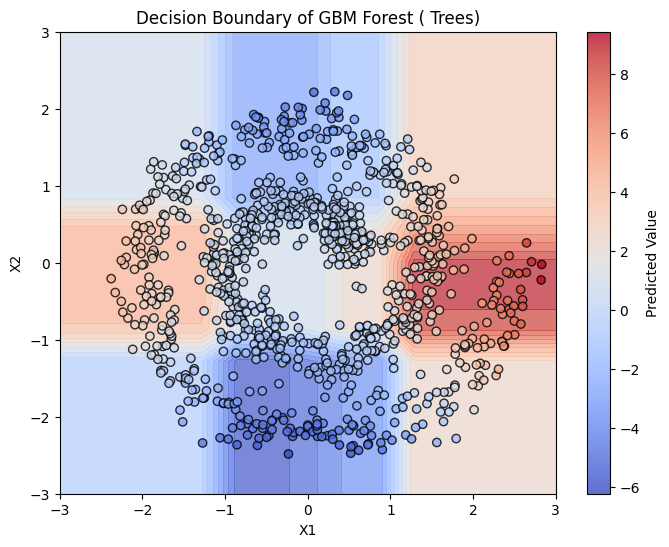

In [28]:
plt.figure(figsize=(8, 6))
plt.contourf(X1_grid, X2_grid, Z_grid.reshape(grid_size,grid_size), levels=20, cmap="coolwarm", alpha=0.7)
plt.scatter(X_np[:, 0], X_np[:, 1], c=Y_np, cmap="coolwarm", edgecolor="k", marker="o", alpha=0.8)
plt.colorbar(label="Predicted Value")
plt.xlabel("X1")
plt.ylabel("X2")
plt.title(f"Decision Boundary of GBM Forest ( Trees)")
plt.show()


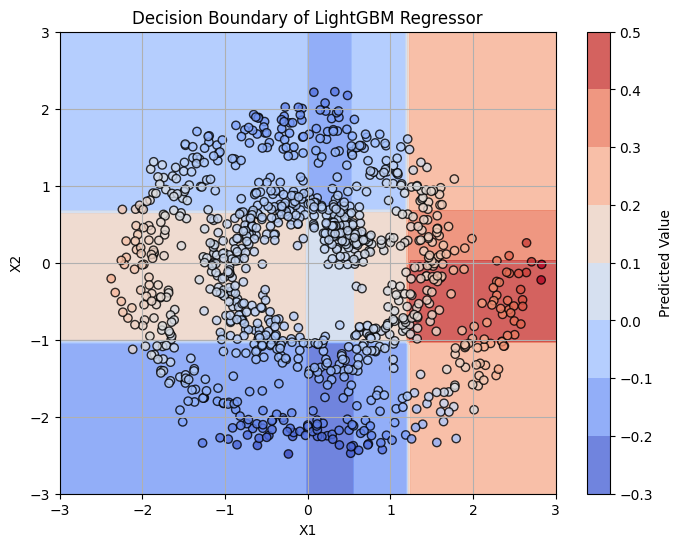

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Create a grid of values over the same domain as your training data
grid_size = 100
x1 = np.linspace(-3, 3, grid_size)
x2 = np.linspace(-3, 3, grid_size)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.c_[X1.ravel(), X2.ravel()]  # shape: (grid_size**2, 2)

# Use LightGBM model to predict on the grid
Z = model.predict(X_grid)
Z = Z.reshape(X1.shape)

# Plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X1, X2, Z, cmap='coolwarm', alpha=0.8)
plt.colorbar(contour, label="Predicted Value")
plt.scatter(X_np[:, 0], X_np[:, 1], c=Y_np, edgecolor="k", cmap="coolwarm", alpha=0.8)
plt.title("Decision Boundary of LightGBM Regressor")
plt.xlabel("X1")
plt.ylabel("X2")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid(True)
plt.show()


In [127]:
'''pytorch profiler'''

# import torch.profiler

# with torch.profiler.profile(
#     activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
#     record_shapes=True,
#     profile_memory=True,
#     with_stack=True
# ) as prof:
#     era_model.fit(X_np, Y_np, eras)

# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))


'pytorch profiler'